# Praca domowa 6
**Krzysztof Dąbrowski**

In [101]:
#%pip install ucimlrepo

In [102]:
from ucimlrepo import fetch_ucirepo 
chess_king_rook_vs_king = fetch_ucirepo(id=23) 
X = chess_king_rook_vs_king.data.features
y = chess_king_rook_vs_king.data.targets 
X["white-depth-of-win"] = y

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Przygotowanie do 3 pytań

a) zmapowanie liter na liczby całkowite (przy okazji mapuję white-depth-of-win na liczby)

In [104]:
pd.set_option('future.no_silent_downcasting', True)

map = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
columns = ['white-king-file', 'white-rook-file', 'black-king-file']
X.loc[:,columns] = X.loc[:,columns].replace(map)

depth_map = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9,
            'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13,'fourteen': 14, 'fifteen': 15, 'sixteen': 16,'draw': -1}
X.loc[:,'white-depth-of-win'] = X.loc[:,'white-depth-of-win'].replace(depth_map)


b) metryki

In [105]:
dist_file = pd.to_numeric(X['white-king-file'] - X['black-king-file'])
dist_rank = pd.to_numeric(X['white-king-rank'] - X['black-king-rank'])

In [106]:
X["Euclidean_dist"] = np.sqrt(dist_file**2 + dist_rank**2)
X["Manhattan_dist"] = dist_file.abs() + dist_rank.abs()
X["Chebyshev_dist"] = np.maximum(dist_file.abs(), dist_rank.abs())

c) odległość czarnego króla od najbliższej krawędzi

In [107]:
distances = [X['black-king-file'] - 1, 8 - X['black-king-file'], X['black-king-rank'] - 1, 8 - X['black-king-rank']]
X["edge_dist"] = np.min(distances, axis = 0)

### Pytanie 1

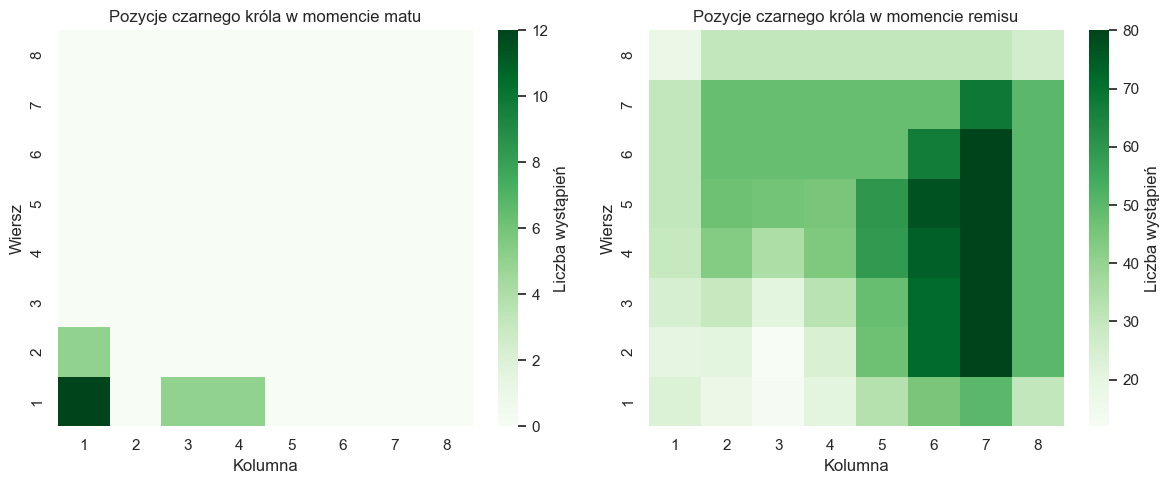

In [108]:
win_data = X[X['white-depth-of-win'] == 0]
win_count = win_data.groupby(['black-king-rank', 'black-king-file']).size().unstack(fill_value=0)
win_board = win_count.reindex(index=range(1, 9), columns=range(1, 9), fill_value=0)

draw_data = X[X['white-depth-of-win'] == -1]
draw_count = draw_data.groupby(['black-king-rank', 'black-king-file']).size().unstack(fill_value=0)
draw_board = draw_count.reindex(index=range(1, 9), columns=range(1, 9), fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(win_board, cmap="Greens", ax=ax1, cbar_kws={'label': 'Liczba wystąpień'})
ax1.set_title("Pozycje czarnego króla w momencie matu")
ax1.set_xlabel("Kolumna")
ax1.set_ylabel("Wiersz")
ax1.invert_yaxis()

sns.heatmap(draw_board, cmap="Greens", ax=ax2, cbar_kws={'label': 'Liczba wystąpień'})
ax2.set_title("Pozycje czarnego króla w momencie remisu")
ax2.set_xlabel("Kolumna")
ax2.set_ylabel("Wiersz")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

Komentarz: Wizualizacja pokazuje, że matowanie czarnego króla następuje niemal wyłącznie w okolicy lewego dolnego rogu planszy. W sytuacjach remisowych król zajmuje szerszy i bardziej centralny obszar, zazwyczaj blisko prawej krawędzi.

### Pytanie 2

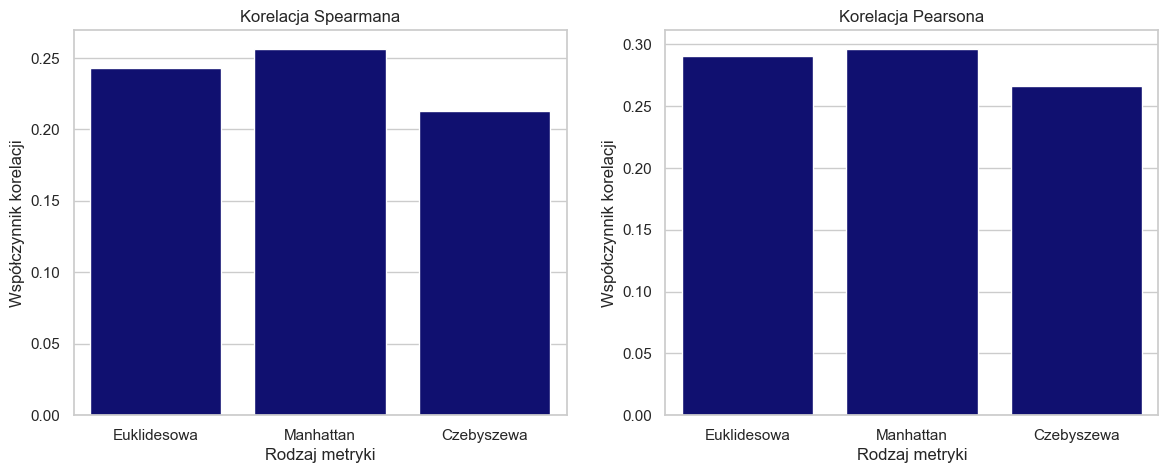

In [109]:
X_no_draw = X[X['white-depth-of-win'] != -1]

corr_spearman = X_no_draw[['white-depth-of-win', 'Euclidean_dist', 'Manhattan_dist', 'Chebyshev_dist']].corr(method='spearman')
corr_pearson = X_no_draw[['white-depth-of-win', 'Euclidean_dist', 'Manhattan_dist', 'Chebyshev_dist']].corr(method='pearson')

data_s = corr_spearman['white-depth-of-win'].drop('white-depth-of-win')
data_p = corr_pearson['white-depth-of-win'].drop('white-depth-of-win')
labels = ['Euklidesowa', 'Manhattan', 'Czebyszewa']
data_s.index = labels
data_p.index = labels

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_theme(style="whitegrid")

sns.barplot(x=data_s.index, y=data_s.values, ax=ax3, color = "navy")
ax3.set_title('Korelacja Spearmana')
ax3.set_ylabel('Współczynnik korelacji')
ax3.set_xlabel('Rodzaj metryki')

sns.barplot(x=data_p.index, y=data_p.values, ax=ax4, color = "navy")
ax4.set_title('Korelacja Pearsona')
ax4.set_ylabel('Współczynnik korelacji')
ax4.set_xlabel('Rodzaj metryki')


plt.show()

Komentarz: Analiza współczynników korelacji Spearmana i Persona wskazuje, że metryka Manhattan najlepiej pozwala oszacować liczbę ruchów do zakończenia gry.

### Pytanie 3

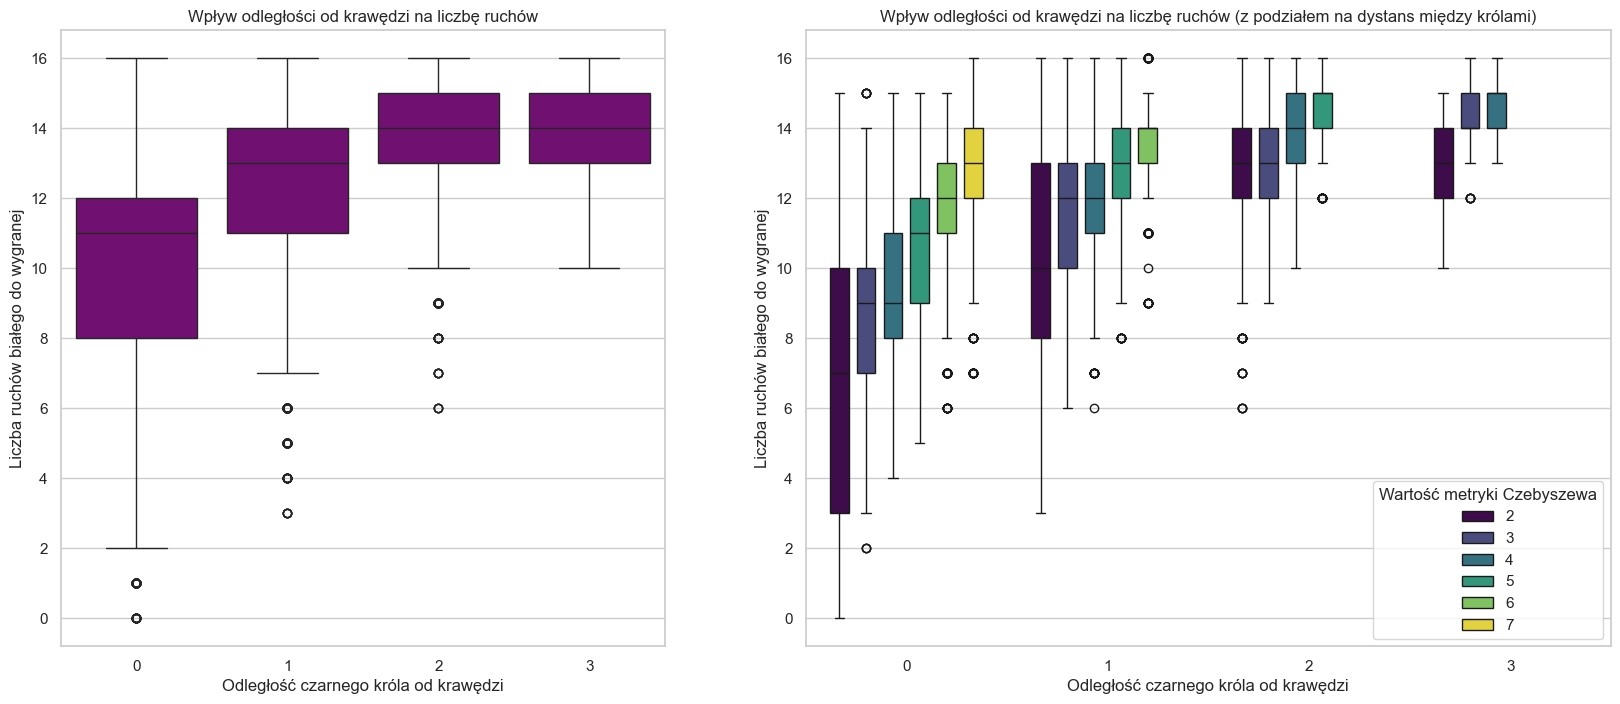

In [110]:
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1.5, 2]})
sns.set_theme(style="whitegrid")

sns.boxplot(data=X_no_draw, x='edge_dist', y='white-depth-of-win', ax=ax5, color="purple")
ax5.set_title('Wpływ odległości od krawędzi na liczbę ruchów')
ax5.set_xlabel('Odległość czarnego króla od krawędzi')
ax5.set_ylabel('Liczba ruchów białego do wygranej')

sns.boxplot(data=X_no_draw, x='edge_dist', y='white-depth-of-win', hue="Chebyshev_dist", palette="viridis", ax=ax6, gap=0.3)
ax6.set_title('Wpływ odległości od krawędzi na liczbę ruchów (z podziałem na dystans między królami)')
ax6.set_xlabel('Odległość czarnego króla od krawędzi')
ax6.set_ylabel('Liczba ruchów białego do wygranej')
ax6.legend(title='Wartość metryki Czebyszewa')

plt.show()

Komentarz: Wykresy potwierdzają, że mniejsza odległość czarnego króla od krawędzi wyraźnie koreluje z szybszym zakończeniem gry (przegraną). Połączenie jej z dystansem między królami pozwala na jeszcze dokładniejsze szacowanie, co widać po wyraźnych różnicach w poziomach median dla poszczególnych grup na prawym wykresie.